In [1]:
import os
import json
import time
import gzip
import bcolz
import numpy as np
import re
import copy
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pickle

## Loading the Dataset

In [2]:
pickleFile = '../Datasets/Reviews/dataset.pkl'
start = time.clock()
dataset = pickle.load( open( pickleFile, "rb" ))
duration = time.clock() - start
print("Loaded the dataset in", round(duration,2), "seconds.")

Loaded the dataset in 9.44 seconds.


In [3]:
print("There are",len(dataset), "amazon items.")

There are 63001 amazon items.


## Loading Glove Words

In [4]:
def loadGlove(glove_path, dim=50):
    acceptedDimensions = [50, 100, 200, 300]
    if dim not in acceptedDimensions:
        print("You didn't choose a right dimension.")
        print("Try one of these:", acceptedDimensions)
        return None
    pickleWordFile = f'{glove_path}/6B.'+str(dim)+'_words.pkl'
    pickleIdFile   = f'{glove_path}/6B.'+str(dim)+'_idx.pkl'
    pickleDatFile  = f'{glove_path}/glove.6B.'+str(dim)+'.dat'
    pickleDataset  = f'{glove_path}/glove.6B.'+str(dim)+'d.txt'
    
    if os.path.isfile(pickleWordFile):
        # check if we've made the outputs before
        print("Preloading files..", end=" ")
        vectors = bcolz.open(pickleDatFile)[:]
        words = pickle.load(open(pickleWordFile, 'rb'))
        word2idx = pickle.load(open(pickleIdFile, 'rb'))
        glove = {w: vectors[word2idx[w]] for w in words}
        print("Done.")
        return glove
    else:
        print("Doesn't work.", end=" ")


gloveDimension = 50
glovePath = "/media/data/Datasets/glove"
glove = loadGlove(glovePath, dim=gloveDimension)
gloveWords = glove.keys()

Preloading files.. Done.


In [5]:
print("Glove Vocabulary Size:",len(gloveWords))

Glove Vocabulary Size: 400000


## Preprocessing Data

In [6]:
def preprocess(paragraph):
    # split paragraph by full stops
    paragraph = paragraph.lower()
    paragraph = re.sub("([,!?()-+&£$.%*'])", r' \1 ', paragraph)
    paragraph = re.sub('\s{2,}', ' ', paragraph)
    paragraph = paragraph.split(" ")
    # remove empty string
    return paragraph

def padSentence(words, maxLength, eosString="<eos>", padString="<pad>"):
    words = words[:maxLength-1] + [eosString]
    return words + [padString for i in range(maxLength - len(words))]
    
def discretise(value, word):
    return word + "_" + str(value)

In [7]:
def handleItem(itemID, dataset=dataset, printDebug=False):
    """
    Filters words out based on whether they're in the GloVe dataset or not.
    
    Parameters:
    
    """


    reviews = []
    for i in range(len(dataset[itemID])):
        # initialise variables
        entry = dataset[itemID][i]
        reviewerID = entry['reviewerID']

        """
        Review Text Processing
        """
        # split sentences
        sentences = re.split(r'(?<=\.) ', entry['reviewText'])
        for s in range(len(sentences)):
            sentence = sentences[s]
            sentences[s] = list(filter(None, preprocess(sentence)))
            
        # preprocess summary
        summary = list(filter(None,preprocess(entry['summary'])))
        
        # merge summary sequence and review sequences together into overall entries.
        if len(sentences) < 2:
            entries =  [["<sos>"] + summary + ["<sor>"]] + [sentences[0] + ["<eos>"]]
        else:
            entries =  [["<sos>"] + summary + ["<sor>"]] + [sentences[0]] + sentences[1:-1] + [sentences[-1] + ["<eos>"]]

        # setup review parameters
        rating   = [discretise(entry['overall'], "rating")]

        # compute polarity
        good, bad = entry['helpful'][0], entry['helpful'][1]
        try:
            polarity = (good - bad) / (good + bad)
        except ZeroDivisionError:
            polarity = 0
        polarity = np.tanh(polarity)
        polarity = np.round(polarity, 1)
        polarity = [discretise(polarity, "polarity")]

        # create identity/conditioning entry
        identifier = itemID.lower()
        identity = [l for l in identifier] + rating + polarity

        # add conditionining entry to each entry
        formatted = [entry for entry in entries]


        if printDebug:
            print("ENTRY:",dataset[itemID][i])
            print("IDENTITY:",identity)


        for i in range(len(formatted)-1):
            # add the conditioning variable to the input. the output value does not have the conditioning variable.
            reviews.append([identity + formatted[i], formatted[i+1]])
            if printDebug:
                print(reviews[-1][0], "->", reviews[-1][1])
        if printDebug:
            break
            
    return reviews

In [8]:
datasetKeys = list(dataset.keys())
k = handleItem(datasetKeys[19],printDebug=True)

ENTRY: {'reviewerID': 'AA8JH8LD2H4P9', 'asin': '7214047977', 'reviewerName': 'Claudia J. Frier', 'helpful': [3, 4], 'reviewText': 'This fits my 7" kindle fire hd perfectly! I love it. It even has a slot for a stylus. The kindle is velcroed in so it\'s nice and secure. Very glad I bought this!', 'overall': 5.0, 'summary': 'love it', 'unixReviewTime': 1354665600, 'reviewTime': '12 5, 2012'}
IDENTITY: ['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', '<sos>', 'love', 'it', '<sor>'] -> ['this', 'fits', 'my', '7"', 'kindle', 'fire', 'hd', 'perfectly', '!', 'i', 'love', 'it', '.']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', 'this', 'fits', 'my', '7"', 'kindle', 'fire', 'hd', 'perfectly', '!', 'i', 'love', 'it', '.'] -> ['it', 'even', 'has', 'a', 'slot', 'for', 'a', 'stylus', '.']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0'

In [9]:
print(len(datasetKeys))

63001


In [10]:
def processItems(func, args, n_processes = 7):
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in enumerate(p.imap_unordered(func, args)):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

In [11]:
reviews = processItems(handleItem,datasetKeys[::16])

100%|██████████| 3938/3938 [00:06<00:00, 620.40it/s]


In [12]:
datasetSize = len(reviews)
trainPortion = 0.8
valPortion = 0.2

trainRatio = int(datasetSize * trainPortion)
valRatio = int(datasetSize * valPortion)

train = reviews[:trainRatio]
validation = reviews[trainRatio:]

print(len(train), len(validation))

# now we need to flatten train and validation.
trainents = []
for review in train:
    trainents += [entry for entry in review]
valents = []
for review in validation:
    valents += [entry for entry in review]
    
train = trainents
validation = valents

print(len(train), len(validation))

3150 788
498155 122831


In [13]:
# get the number of itemIDs
for row in train:
    print(row)
    break

[['3', '9', '3', '0', '9', '9', '2', '8', '6', '8', 'rating_5.0', 'polarity_0.0', '<sos>', 'harddrive', '<sor>'], ['brought', 'back', 'my', 'ipod', 'video', '30g', 'back', 'life', ',', 'easy', 'to', 'replace', '.']]


## Getting ID's of words

To improve the throughput of the model, we should reduce the embedding size. Here we'll look at all the words and keep track ones that exist. We'll make a reduced word2id based on this set.

In [14]:
wordcounts = {}

In [15]:
# here we reduce the size of the dataset so we can debug our model.
print("Subsetting Reviews..")
print("We now have", len(train), "reviews.")

Subsetting Reviews..
We now have 498155 reviews.


In [16]:
# get word frequency for words in training data
for row in tqdm(train):
    for sequences in row:
        for word in sequences:
            word = str(word)
            if word not in wordcounts:
                wordcounts[word] = 0
            wordcounts[word] += 1

100%|██████████| 498155/498155 [00:08<00:00, 55847.77it/s]


In [17]:
# get words that are not in the glove dataset
knowns   = [word for word in wordcounts if word in glove]
unknowns = [word for word in wordcounts if word not in glove]
# sort words by their frequency
wordOrder = list(sorted(knowns, key=lambda x: wordcounts[x], reverse=True))

In [18]:
print(len(knowns), len(unknowns))

43023 96140


In [19]:
vocabularyLimit = 30000

In [20]:
wordOrder = wordOrder[:vocabularyLimit]

In [21]:
weights = [glove[word] for word in wordOrder]

In [22]:
for word in unknowns:
    if ("rating" in word) or ("polarity" in word):
        try:
            part = word.split("_")
            if part[1] == "-0.0":
                part[1] = "0.0"
            weight = glove[part[0]] + glove[part[1]]
            wordOrder.append(word)
            weights.append(weight)
        except:
            pass

In [23]:
# create dictionaries for constant time referencing
id2word = {idx: w for (idx, w) in enumerate(wordOrder)}
word2id = {w: idx for (idx, w) in enumerate(wordOrder)}

In [24]:
lim = len(word2id)
# add <eos> (end of sequence)
weights.append(glove['eos'])
word2id['<eos>'] = lim
id2word[lim] = '<eos>'
lim += 1

# add <sos> (start of sequence)
weights.append(glove['sos'])
word2id['<sos>'] = lim
id2word[lim] = ['<sos>']
lim += 1

# add <sor> (start of review)
sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<sor>'] = lim
id2word[lim] = '<sor>'
lim += 1

# add <unk> (unknown token)
weights.append(glove['unk'])
word2id['<unk>'] = lim
id2word[lim] = '<unk>'

# add <pad> 
id2word[len(word2id)] = "<pad>"
word2id["<pad>"] = len(word2id)
weights.append(np.random.normal(0,0,gloveDimension))

In [25]:
np.random.normal(0,0,gloveDimension)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
def wordToID(word,corp=word2id):
    if word in corp:
        return corp[word]
    return corp['<unk>']

def IDToWord(id,corp=id2word, ref=word2id):
    if word in corp:
        return corp[word]
    return corp[ref['<unk>']]

In [27]:
# convert words to their id's in the review.
def entriesToWordIDs(group):
    return [[[wordToID(word) for word in seq] for seq in row] for row in tqdm(group)]
    
train = entriesToWordIDs(train)
validation = entriesToWordIDs(validation)

100%|██████████| 122831/122831 [00:01<00:00, 98194.57it/s]


In [28]:
sizes = {}
for row in train:
    for seq in row:
        length = len(seq)
        if length not in sizes:
            sizes[length] = 0
        sizes[length] += 1

seqlengths = list(sorted(sizes.keys(), key=lambda x: sizes[x], reverse=True))
print("The longest sequence in our dataset is",max(seqlengths),"tokens long.")

The longest sequence in our dataset is 1697 tokens long.


In [29]:
for i in range(1709):
    if i not in sizes:
        sizes[i] = 0

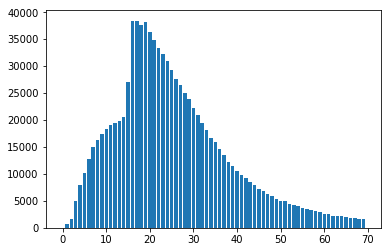

In [30]:
ents = [x for x in range(0,70)]
bins = [sizes[x] for x in ents]
plt.bar(ents,bins)
plt.show()

In [31]:
cutoff = 60
print("Cutoff sequence length:", cutoff)

Cutoff sequence length: 60


In [32]:
def trimSeq(group):
    return [[seq[:cutoff] for seq in row] for row in tqdm(group)]

train = trimSeq(train)
validation = trimSeq(validation)

100%|██████████| 122831/122831 [00:00<00:00, 684247.61it/s]


In [33]:
# create container ready for use in dataset
# we do not add padding here as we want to reduce storage size!
container = {
    'id2word' : id2word,
    'word2id' : word2id,
    'train' : train,
    'validation': validation,
    'weights' : np.matrix(weights),
    'cutoff' : cutoff
}

In [34]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0
        
        
datasetFile = '../Datasets/Reviews/dataset_ready.pkl'
# save the dataset to a pickle file.
output = open(datasetFile, 'wb')
pickle.dump(container, output)
output.close()
print("Saved!", convert_bytes(os.stat(datasetFile).st_size))

Saved! 98.3 MB


In [35]:
len(train[0][::32])

1

In [36]:
import torch

In [37]:
# get sequence lengths for train and validation data
trainx = [x[0] for x in train]
trainy = [x[1] for x in train]
valx   = [x[0] for x in validation]
valy   = [x[1] for x in validation]

In [38]:

"""
Dataset batching mechanism
"""

def padSeq(row, maxlength, padID, cutoff):
    currentLength = len(row)
    difference = maxlength - currentLength
    return row + [padID for _ in range(difference)]


def batchData(dataset, padID, device, batchsize=32, cutoff=50):
    """
    Splits the dataset into batches.
    Each batch needs to be sorted by 
    the length of their sequence in order
    for `pack_padded_sequence` to be used.
    """
    datasize = len(dataset)
    batches = []
    # split data into batches.
    for i in range(0, datasize, batchsize):
        batches.append(dataset[i:i+batchsize])
    # within each batch, sort the entries.
    for i in range(len(batches)):
        batch = batches[i]
        # get lengths of each review in the batch
        # based on the postion of the EOS tag.
        lengths = [len(seq) for seq in batch]
        indexes = [x for x in range(len(lengths))]
        sortedindexes = sorted(list(zip(lengths, indexes)), reverse=True)

        # since sentences are split by period, the period itself acts
        # the token to identify that the sentence has ended.
        # i.e. we don't need another token identifying the end of the subsequence.

        # get the reviews based on the sorted batch lengths
        reviews = [padSeq(batch[i[1]], cutoff, padID, cutoff)
                   for i in sortedindexes]

        reviews = torch.tensor(reviews, dtype=torch.long, device=device)
        # re-allocate values.
        batches[i] = (reviews, [i[0] for i in sortedindexes])
    return batches
device = "cpu"
batchsize = 32
cutoff = cutoff
trainx_p = batchData(trainx, word2id['<pad>'], device, batchsize, cutoff)
trainy_p = batchData(trainy, word2id['<pad>'], device, batchsize, cutoff)
valx_p = batchData(valx, word2id['<pad>'], device, batchsize, cutoff)
valy_p = batchData(valy, word2id['<pad>'], device, batchsize, cutoff)

train_p = (trainx_p, trainy_p)
val_p = (valx_p, valy_p)

In [39]:
weightshape = np.matrix(weights).shape
weightshape

(30020, 50)

In [40]:
import torch.nn.functional as F
import torch.nn as nn

In [41]:
for batch in range(len(train_p[0])):
    # load x, y from batch
    entry_x, entry_y = train_p[0][batch], train_p[1][batch]
    # sepeate data from sentence lengths
    y_outs, y_seqs = entry_y
    
    # get y_length
    y_len = len(y_outs[0])
    
    num_classes = weightshape[0]
    batch_size = y_outs.shape[0]
    
    loss = nn.BCEWithLogitsLoss()
    # iterate through the words in y
    for w in range(y_len):
        # get indexes of future words
        labels = y_outs[:,w:].long().unsqueeze(2)
        print(labels.shape)
        # set up bag of words container
        bow = torch.FloatTensor(batch_size, y_len-w, num_classes).zero_()
        # create SBOW
        bow.scatter_(2, labels, 1)
        # sum by dimension and limit values between 0 and 1
        bow = torch.sum(bow, dim=1).clamp(0,1)
#         print(bow[0])
#         print("BOW:",bow.shape)
        
        # generate some random matrix of the same shape
        guess = torch.rand(batch_size, num_classes)
#         print("GUESS",guess.shape)
#         crit = F.cross_entropy(ignore_index=word2id['pad'])
        err = loss(guess,bow)
        print(err)
    break

torch.Size([32, 60, 1])
tensor(0.9838)
torch.Size([32, 59, 1])
tensor(0.9835)
torch.Size([32, 58, 1])
tensor(0.9832)
torch.Size([32, 57, 1])
tensor(0.9836)
torch.Size([32, 56, 1])
tensor(0.9834)
torch.Size([32, 55, 1])
tensor(0.9835)
torch.Size([32, 54, 1])
tensor(0.9837)
torch.Size([32, 53, 1])
tensor(0.9835)
torch.Size([32, 52, 1])
tensor(0.9839)
torch.Size([32, 51, 1])
tensor(0.9837)
torch.Size([32, 50, 1])
tensor(0.9839)
torch.Size([32, 49, 1])
tensor(0.9836)
torch.Size([32, 48, 1])
tensor(0.9837)
torch.Size([32, 47, 1])
tensor(0.9839)
torch.Size([32, 46, 1])
tensor(0.9839)
torch.Size([32, 45, 1])
tensor(0.9835)
torch.Size([32, 44, 1])
tensor(0.9838)
torch.Size([32, 43, 1])
tensor(0.9836)
torch.Size([32, 42, 1])
tensor(0.9838)
torch.Size([32, 41, 1])
tensor(0.9837)
torch.Size([32, 40, 1])
tensor(0.9836)
torch.Size([32, 39, 1])
tensor(0.9841)
torch.Size([32, 38, 1])
tensor(0.9839)
torch.Size([32, 37, 1])
tensor(0.9837)
torch.Size([32, 36, 1])
tensor(0.9835)
torch.Size([32, 35, 1])
t

In [42]:
num_classes = 3
labels = torch.LongTensor([[[2,1,0]], [[0,1,0]]]).permute(0,2,1) # Let this be your current batch
print(labels.shape)
batch_size, k, _ = labels.size()
labels_one_hot = torch.FloatTensor(batch_size, k, num_classes).zero_()
print(labels_one_hot.shape)
labels_one_hot.scatter_(2, labels, 1)

torch.Size([2, 3, 1])
torch.Size([2, 3, 3])


tensor([[[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.]]])

In [43]:
torch.zeros(3, 5).scatter_(0, torch.tensor([[0, 1, 2, 0, 0], [2, 0, 0, 1, 2]]), x)

NameError: name 'x' is not defined

In [ ]:
qwer = torch.tensor([[2], [3]])
print(qwer.shape)
z = torch.zeros(2, 4)
print(z.shape)
z.scatter_(1, qwer, 1.23)